# CellCycleLifting Tutorial

***
This notebook shows how to import a dataset, with the desired lifting, and how to run a neural network using the loaded data.

The notebook is divided into sections:

- [Loading the dataset](#loading-the-dataset) loads the config files for the data and the desired tranformation, createsa a dataset object and visualizes it.
- [Create NN model](#create-nn-model) defines a simple neural network to test that the lifting creates the expected incidence matrices.
- [Run](#run) simply runs a forward pass of the model to check that everything is working as expected.

***
***

Note that for simplicity the notebook is setup to use a simple graph, however there is a set of available datasets that you can play with.

To switch to one of the available datasets, simply change the *dataset_name* variable in [Dataset config](#dataset-config) to one of the following names:

* cocitation_cora
* cocitation_citeseer
* cocitation_pubmed
* MUTAG
* NCI1
* NCI109
***

### Imports and utilities

In [1]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2

In [2]:
import pprint
import rootutils
import json

rootutils.setup_root("./", indicator=".project-root", pythonpath=True)
root_folder = rootutils.find_root()
import omegaconf
import torch
from modules.io.load.loaders import GraphLoader

## Loading the dataset

The dataset for this notebook is a manually created dataset with a single graph.

The configs to create the dataset are saved in a yaml file that is loaded using `omegaconf`.

Similarly the parameters for the tranformation to apply to the data are saved in another yaml file.

### Dataset config

In [3]:
dataset_name = "manual_dataset"

dataset_config = omegaconf.OmegaConf.load(
    f"{root_folder}/configs/dataset/{dataset_name}.yaml"
)

# Print config file for nice visualization
dict2print = dataset_config.copy()
pprint.pp(dict(dict2print))

{'data_domain': 'graph',
 'data_type': 'toy_dataset',
 'data_name': 'manual',
 'data_dir': '/Users/gbg141/Documents/TopoProjectX/challenge-icml-2024/datasets/graph/toy_dataset',
 'num_features': 1,
 'num_classes': 2,
 'task': 'classification',
 'loss_type': 'cross_entropy',
 'monitor_metric': 'accuracy',
 'task_level': 'node'}


### Transform config

The *tranform_config* dictionary can contain a sequence of tranforms if it is needed.

In [4]:
# Define lifting type
lifting_type = "graph2cell"

# Define lifting id (name)
id_lifting = "cycle_lifting"

# Read yaml file
transform_config = {
    "lifting": omegaconf.OmegaConf.load(
        f"{root_folder}/configs/transforms/liftings/{lifting_type}/{id_lifting}.yaml"
    )
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}

# Print config file for nice visualization
dict2print = transform_config.copy()
dict2print["lifting"] = dict(dict2print["lifting"])

pprint.pp(dict(dict2print))

{'lifting': {'transform_type': 'lifting',
             'transform_name': 'CellCycleLifting',
             'max_cell_length': None,
             'preserve_edge_attr': False,
             'feature_lifting': 'ProjectionSum'}}


### Load dataset

In [5]:
dataset = GraphLoader(dataset_config, transform_config).load()

Processing...
Done!


### Visualize graph

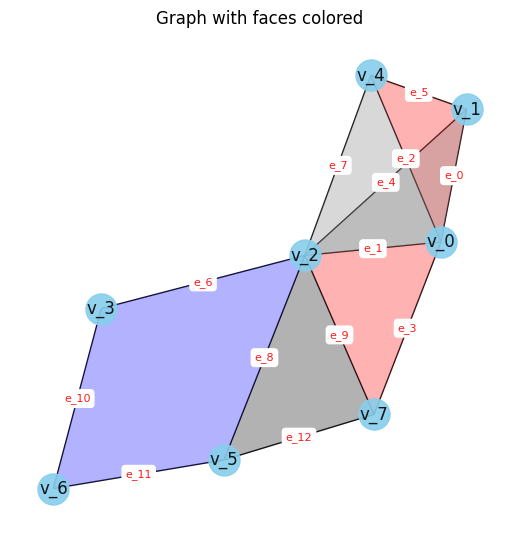

In [6]:
from modules.io.utils.utils import plot_manual_graph

plot_manual_graph(dataset)

In [7]:
incidence_2 = dataset.incidence_2.coalesce()
indices = incidence_2.indices()

for cell_idx in torch.unique(indices[1]):
    corresponding_idxs = indices[1] == cell_idx
    edges = indices[0, corresponding_idxs]
    print(f"Cell {cell_idx} is composed from the edges {edges.numpy()}")

Cell 0 is composed from the edges [1 3 9]
Cell 1 is composed from the edges [ 8  9 12]
Cell 2 is composed from the edges [ 6  8 10 11]
Cell 3 is composed from the edges [0 2 5]
Cell 4 is composed from the edges [1 2 7]
Cell 5 is composed from the edges [0 1 4]


## Create NN Model

In [8]:
from topomodelx.nn.cell.cwn import CWN
import torch


class Network(torch.nn.Module):
    def __init__(
        self,
        in_channels_0,
        in_channels_1,
        in_channels_2,
        hidden_channels,
        out_channels,
        n_layers=1,
    ):
        super().__init__()
        self.base_model = CWN(
            in_channels_0,
            in_channels_1,
            in_channels_2,
            hidden_channels,
            n_layers,
        )
        self.linear_0 = torch.nn.Linear(hidden_channels, out_channels)
        self.linear_1 = torch.nn.Linear(hidden_channels, out_channels)
        self.linear_2 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x_0, x_1, x_2 = self.base_model(
            data.x_0,
            data.x_1,
            data.x_2,
            data.adjacency_1,
            data.incidence_2,
            data.incidence_1.T,
        )
        x_0 = self.linear_0(x_0)
        x_1 = self.linear_1(x_1)
        x_2 = self.linear_2(x_2)
        return x_0, x_1, x_2

In [9]:
n_layers = 2
in_channels_0 = dataset_config["num_features"]
in_channels_1 = dataset_config["num_features"]
in_channels_2 = dataset_config["num_features"]
hidden_channels = 32
out_channels = dataset_config["num_classes"]

model = Network(
    in_channels_0=in_channels_0,
    in_channels_1=in_channels_1,
    in_channels_2=in_channels_2,
    hidden_channels=hidden_channels,
    out_channels=out_channels,
    n_layers=n_layers,
)

## Run

In [10]:
y_hat = model(dataset)